# Part1:

In [1]:
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import ParameterGrid
from models import SARSA,QLearning,ExpectedSARSA
from tqdm import tqdm
import pandas as pd
import numpy as np
from gym.spaces.prng import seed
import random

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def run_experiment(agent,description=""):
    SEGMENTS = 100
    TRAIN_EPISODES = 10
    TEST_EPISODES = 1
    RUNS = 10
    
    train_scores = []
    test_scores = []
    pbar = tqdm(range(RUNS))
    
    for run in pbar:
        agent.reset()
        for segment in range(SEGMENTS):
            pbar.set_description(f"SEGMENT {segment:2d} | "+description)
            train_scores.append(agent.run(n_episodes=TRAIN_EPISODES,verbose=0))
            test_scores.append(agent.run(n_episodes=TEST_EPISODES,mode="test",verbose=0,render=False))
    
    train_scores = np.array(train_scores).reshape(RUNS,SEGMENTS,TRAIN_EPISODES)
    test_scores = np.array(test_scores).reshape(RUNS,SEGMENTS,TEST_EPISODES)
    return train_scores,test_scores


In [3]:
def run_grid_search(algorithm,grid,n_seed=42):
    parameters = ParameterGrid(grid)
    history = []
    results_df = pd.DataFrame(columns=["init_temperature","alpha","avg_reward_train","avg_reward_test"])
    print(f"The grid contains {len(parameters)} rows")
    for param in parameters:
        agent = algorithm('Taxi-v2',
                    exploration="softmax",
                    init_temperature=param["init_temperature"],
                    decay=1, 
                    alpha=param["alpha"], 
                    gamma=.9
        )

        description = "training with params:"+" - ".join(map(lambda x:f"{x[0]}={x[1]:1.2f}",param.items()))
        train_scores,test_scores = run_experiment(agent,description = description)
        history.append((train_scores,test_scores))

        avg_reward_test  = test_scores[:,-1,:].mean()
        avg_reward_train = train_scores[:,-1,:].mean()
        results_df = results_df.append(pd.DataFrame([{'alpha': param["alpha"], 
                                                      'init_temperature': param["init_temperature"],
                                                      'avg_reward_train':avg_reward_train,
                                                      'avg_reward_test':avg_reward_test}]),sort=True,ignore_index=True)
    
    return history, results_df


In [4]:
def plot_parameter_influence(grid_results):
    plt.rcParams['figure.figsize'] = 15, 5
    
    # Plot Testing results
    ax = plt.subplot(1,2,2)
    for init_temperature in grid_results["init_temperature"].unique():
        grid_results.loc[grid_results["init_temperature"]==init_temperature].plot(x="alpha",y="avg_reward_test",ax=ax,marker="o", linestyle='dashed',label=f"Temperature = {init_temperature}")
    for i,row in grid_results.iterrows():
        ax.annotate(i, (row["alpha"], row["avg_reward_test"]),xytext=(5,10),textcoords='offset points')
        
    plt.ylabel("Final Reward")
    plt.xlabel("Learning Rate")
    plt.title("Parameters influence on the final reward - Testing")
    
    # Plot Training results
    ax = plt.subplot(1,2,1)
    for init_temperature in grid_results["init_temperature"].unique():
        grid_results.loc[grid_results["init_temperature"]==init_temperature].plot(x="alpha",y="avg_reward_train",ax=ax,marker="o", linestyle='dashed',label=f"Temperature = {init_temperature}")
    
    for i,row in grid_results.iterrows():
        ax.annotate(i, (row["alpha"], row["avg_reward_train"]),xytext=(5,10),textcoords='offset points')
    plt.ylabel("Final Reward")
    plt.xlabel("Learning Rate")
    plt.title("Parameters influence on the final reward - Training")

    plt.show()
    
def plot_learning_curves(history,best_idx):
    plt.rcParams['figure.figsize'] = 15, 10
    train_arr,test_arr = history[best_idx]
    
    # Plot Learning curves
    plt.subplot(2,2,1)
    plt.plot(train_arr.mean((0,2)).reshape(-1,1))
    plt.title("Learning curve - mean - training")
    plt.xlabel("Training segments")
    plt.ylabel("Averaged Reward")
    
    plt.subplot(2,2,2)
    plt.plot(train_arr.std((0,2)).reshape(-1,1))
    plt.title("Learning curve - std - training")
    plt.ylabel("Standard Deviation of Reward")
    plt.xlabel("Training segments")
    
    plt.subplot(2,2,3)
    plt.plot(test_arr.mean(0))
    plt.title("Learning curve - mean - testing")
    plt.ylabel("Averaged Reward")
    plt.xlabel("Testing segments")
    
    plt.subplot(2,2,4)
    plt.plot(test_arr.std(0))
    plt.title("Learning curve - std - testing")
    plt.ylabel("Standard Deviation of Reward")
    plt.xlabel("Testing segments")

    plt.show()


In [5]:
grid = {
    "init_temperature":[.25, 1, 4],
    "alpha":[.1,0.5,.9]
}


## Sarsa

In [6]:
sarsa_history, sarsa_results_df = run_grid_search(SARSA,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT  0 | training with params:alpha=0.10 - init_temperature=0.25:   0%|          | 0/10 [00:00<?, ?it/s]

The grid contains 9 rows


SEGMENT 99 | training with params:alpha=0.10 - init_temperature=0.25: 100%|██████████| 10/10 [01:29<00:00,  8.91s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=1.00: 100%|██████████| 10/10 [01:54<00:00, 11.40s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=4.00: 100%|██████████| 10/10 [02:29<00:00, 14.91s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=0.25: 100%|██████████| 10/10 [00:34<00:00,  3.45s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=1.00: 100%|██████████| 10/10 [00:45<00:00,  4.56s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=4.00: 100%|██████████| 10/10 [01:12<00:00,  7.27s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0.25: 100%|██████████| 10/10 [00:32<00:00,  3.23s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=1.00: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temp

In [7]:
sarsa_results_df

,alpha,avg_reward_test,avg_reward_train,init_temperature
0,0.1,-74.5,-9.14,0.25
1,0.1,-94.2,-61.26,1.00
2,0.1,-158.5,-224.46,4.00
3,0.5,8.9,8.18,0.25
4,0.5,8.3,8.25,1.00
5,0.5,-14.1,7.02,4.00
6,0.9,8.2,7.58,0.25
7,0.9,7.2,7.61,1.00
8,0.9,-12.6,6.90,4.00


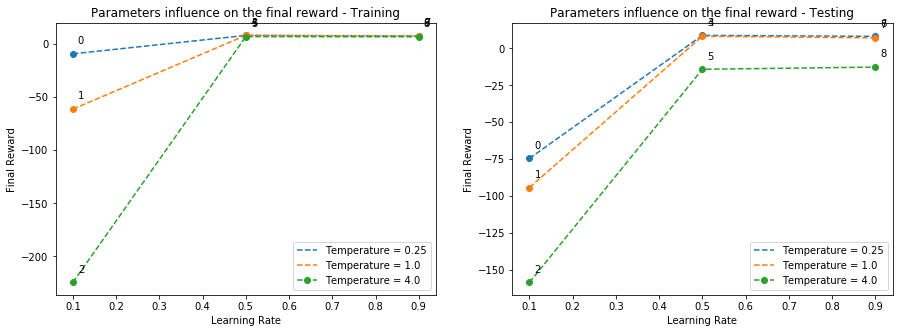

In [9]:
plot_parameter_influence(sarsa_results_df)

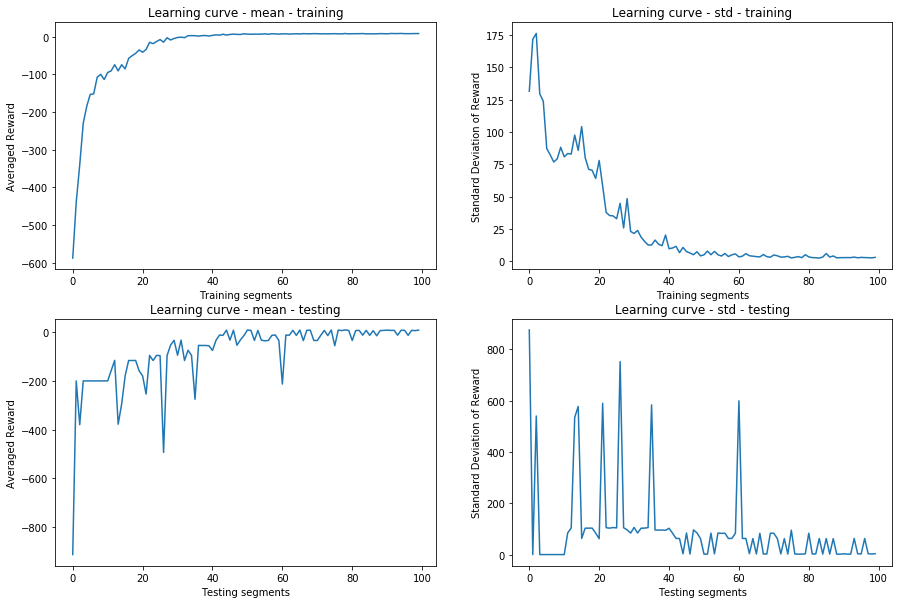

In [10]:
plot_learning_curves(sarsa_history,best_idx=3)

## QLearning

In [11]:
q_history, q_results_df = run_grid_search(QLearning,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT  0 | training with params:alpha=0.10 - init_temperature=0.25:   0%|          | 0/10 [00:00<?, ?it/s]

The grid contains 9 rows


SEGMENT 99 | training with params:alpha=0.10 - init_temperature=0.25: 100%|██████████| 10/10 [01:43<00:00, 10.33s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=1.00: 100%|██████████| 10/10 [02:15<00:00, 13.56s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=4.00: 100%|██████████| 10/10 [02:37<00:00, 15.72s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=0.25: 100%|██████████| 10/10 [00:43<00:00,  4.39s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=1.00: 100%|██████████| 10/10 [00:48<00:00,  4.85s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=4.00: 100%|██████████| 10/10 [01:01<00:00,  6.14s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0.25: 100%|██████████| 10/10 [00:33<00:00,  3.39s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=1.00: 100%|██████████| 10/10 [00:43<00:00,  4.35s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temp

In [12]:
q_results_df

,alpha,avg_reward_test,avg_reward_train,init_temperature
0,0.1,-95.5,-6.71,0.25
1,0.1,-95.4,-42.85,1.00
2,0.1,-12.8,-186.46,4.00
3,0.5,8.2,8.46,0.25
4,0.5,7.9,7.31,1.00
5,0.5,8.1,7.18,4.00
6,0.9,8.9,8.07,0.25
7,0.9,-12.3,7.22,1.00
8,0.9,-13.9,6.45,4.00


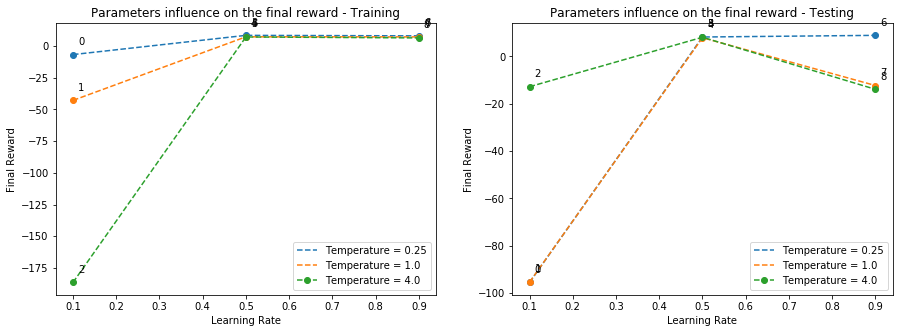

In [13]:
plot_parameter_influence(q_results_df)

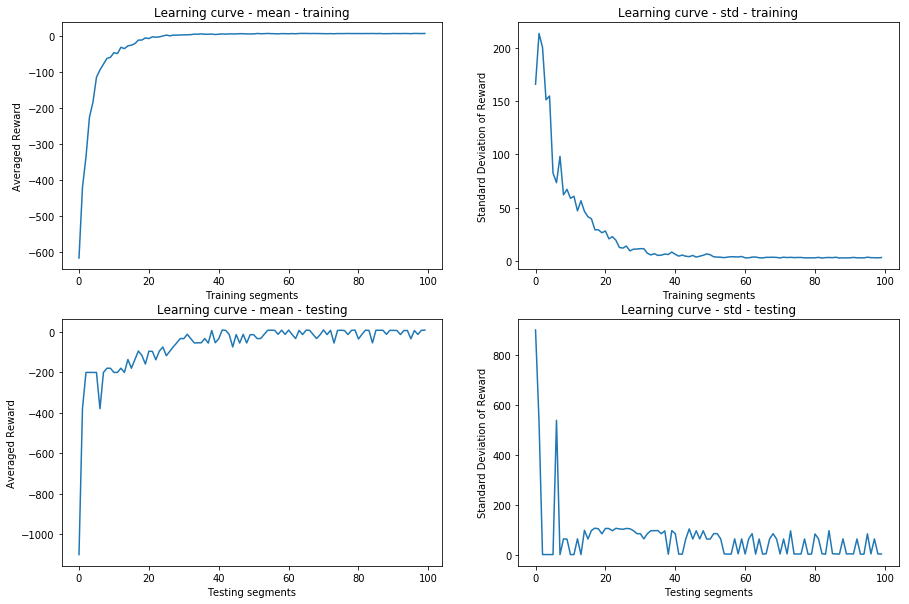

In [23]:
plot_learning_curves(q_history,best_idx=6)

## ExpectedSARSA

In [15]:
exsarsa_history, exsarsa_results_df = run_grid_search(ExpectedSARSA,grid)

/Users/abderrahim/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
SEGMENT  0 | training with params:alpha=0.10 - init_temperature=0.25:   0%|          | 0/10 [00:00<?, ?it/s]

The grid contains 9 rows


SEGMENT 99 | training with params:alpha=0.10 - init_temperature=0.25: 100%|██████████| 10/10 [01:59<00:00, 11.91s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=1.00: 100%|██████████| 10/10 [02:28<00:00, 14.86s/it]
SEGMENT 99 | training with params:alpha=0.10 - init_temperature=4.00: 100%|██████████| 10/10 [03:31<00:00, 21.10s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=0.25: 100%|██████████| 10/10 [00:47<00:00,  4.76s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=1.00: 100%|██████████| 10/10 [01:01<00:00,  6.17s/it]
SEGMENT 99 | training with params:alpha=0.50 - init_temperature=4.00: 100%|██████████| 10/10 [01:22<00:00,  8.27s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=0.25: 100%|██████████| 10/10 [00:37<00:00,  3.72s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temperature=1.00: 100%|██████████| 10/10 [00:48<00:00,  4.89s/it]
SEGMENT 99 | training with params:alpha=0.90 - init_temp

In [20]:
exsarsa_results_df

,alpha,avg_reward_test,avg_reward_train,init_temperature
0,0.1,-116.1,-12.00,0.25
1,0.1,-74.1,-39.44,1.00
2,0.1,-74.0,-198.01,4.00
3,0.5,-12.7,8.17,0.25
4,0.5,9.3,8.22,1.00
5,0.5,-12.7,7.58,4.00
6,0.9,6.7,8.26,0.25
7,0.9,7.5,7.46,1.00
8,0.9,7.7,6.52,4.00


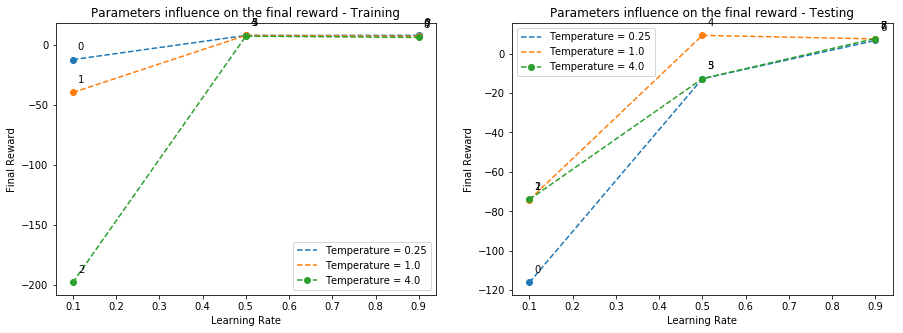

In [21]:
plot_parameter_influence(exsarsa_results_df)

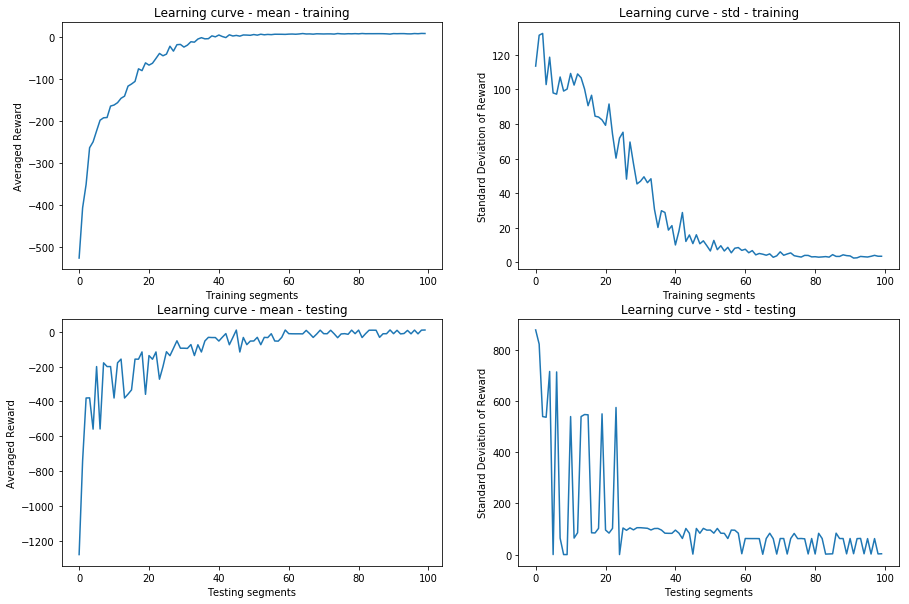

In [22]:
plot_learning_curves(exsarsa_history,best_idx=4)

**Discussion:**

- 